# Introduction to Project Data Analysis

## Overview of the Dataset

This project involves a detailed analysis of a dataset encompassing sales, promotional activities, and product information in a retail setting. The data spans from March 1, 2022, to June 27, 2023, and includes various attributes related to product sales, discounts, and promotions across different store types and product categories. 

## Objectives of the Analysis

The main goals of our analysis are to:

1. **Identify Sales Trends and Seasonal Variations**: We aim to explore how sales figures change over time, particularly from March 2022 to June 2022, and understand the influence of seasonal factors or other external variables on these trends.

2. **Examine Weekly Sales Fluctuations**: By analyzing weekly sales data, we seek to uncover patterns that might be linked to specific promotional events or other recurring factors.

3. **Conduct a Correlation Analysis of Key Features**: We will investigate the relationships between various factors such as:
   - Sales and discount percentages.
   - Promotional activities and their impact on sales.
   - Interdependencies between different product categories.

## Preliminary Insights

The initial phase of our analysis will involve:
- A comprehensive examination of product types, with a focus on 11,109 distinct products.
- Categorizing stores into different clusters based on their characteristics.
- Analyzing sales data to determine the proportion of unsold products and understand sales distribution (average, median, outliers).
- Reviewing pricing strategies and their variance across the product range.

## Expected Outcomes

The insights gained from this analysis will not only provide a clearer understanding of the sales dynamics within this retail dataset but will also aid in making informed decisions regarding product placement, promotional strategies, and pricing models.


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

In [100]:
def basic_details(df):
    """Returns basic statistics for dataset - duplicates,
    % of zero, nan, unique values, min, max, mean, median and standard deviation."""
    b = pd.DataFrame()
    b['Missing, %'] = round(df.isnull().sum()/df.shape[0]*100, 2)
    b['Zero, %'] = round(df.isin([0]).sum() /df.shape[0]*100, 2)
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    b.loc[numeric_cols, 'Min'] = df[numeric_cols].min().round(2)
    b.loc[numeric_cols, '1%'] = df[numeric_cols].quantile(0.01)
    b.loc[numeric_cols, '25%'] = df[numeric_cols].quantile(0.25)
    b.loc[numeric_cols, 'Mean'] = df[numeric_cols].mean().round(2)
    b.loc[numeric_cols, 'Median'] = df[numeric_cols].median().round(2)
    b.loc[numeric_cols, '75%'] = df[numeric_cols].quantile(0.75)
    b.loc[numeric_cols, '99%'] = df[numeric_cols].quantile(0.99)
    b.loc[numeric_cols, 'Max'] = df[numeric_cols].max().round(2)
    b.loc[numeric_cols, 'Std'] = df[numeric_cols].std().round(2)
        
    # Display the shape of the dataset
    print("\nShape of the dataset:")
    print(f"Number of Rows: {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")
    print(f"Dataset has NULL values: {df.isnull().sum().any()}")
    # Check for duplicates
    num_duplicates = df.duplicated().sum()
    if num_duplicates == 0:
        print("No duplicates found.")
    else:
        print(f"Duplicates found: {num_duplicates}")
    # Display the first few rows of the dataset
    print("\nFirst few rows of the dataset:")
    display(df.head())

    return b

In [101]:
# load dataset
df = pd.read_csv('dataset.csv')
# check for duplicates
print(f"Duplicates found: {df.duplicated().sum()}")


Duplicates found: 23621


In [102]:
# Remove duplicates
df = df.drop_duplicates()

In [103]:
# view basic details of dataset
basic_details(df)


Shape of the dataset:
Number of Rows: 792726
Number of Columns: 11
Dataset has NULL values: False
No duplicates found.

First few rows of the dataset:


,date,product_id,store_cluster_id,sales,shelf_price,has_promo,category_3_promo_coverage,discount_percent,category_1,category_2,category_3
0,2023-04-11,0,1,31.0,26.90,0,0.032787,0.000000,0,0,0
1,2023-04-11,1,1,0.0,384.49,0,0.000000,0.000000,1,1,1
2,2023-04-11,2,2,0.0,15.20,0,0.000000,0.000000,2,2,2
3,2023-04-11,3,1,12.0,149.90,1,0.058824,0.200133,0,0,3
4,2023-04-11,4,1,0.0,274.99,0,0.000000,0.000000,1,1,1


,"Missing, %","Zero, %",N unique value,dtype,Min,1%,25%,Mean,Median,75%,99%,Max,Std
date,0.0,0.00,70,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,0.0,0.00,11109,int64,0.00,87.00,2659.00,5399.36,5520.00,8165.000000,10918.000000,11108.00,3228.71
store_cluster_id,0.0,0.00,2,int64,1.00,1.00,1.00,1.50,1.00,2.000000,2.000000,2.00,0.50
sales,0.0,21.77,22817,float64,0.00,0.00,1.00,32.76,6.20,25.000000,318.000000,31811.00,308.21
shelf_price,0.0,0.00,5410,float64,0.05,4.29,24.74,80.23,43.90,89.240000,519.900000,6501.49,119.68
has_promo,0.0,91.45,2,int64,0.00,0.00,0.00,0.09,0.00,0.000000,1.000000,1.00,0.28
category_3_promo_coverage,0.0,40.32,1396,float64,0.00,0.00,0.00,0.08,0.04,0.137931,0.428571,1.00,0.11
discount_percent,0.0,93.29,6409,float64,0.00,0.00,0.00,0.01,0.00,0.000000,0.286533,0.96,0.06
category_1,0.0,4.12,15,int64,0.00,0.00,1.00,5.92,7.00,10.000000,11.000000,14.00,4.11
category_2,0.0,0.70,76,int64,0.00,1.00,20.00,32.90,33.00,44.000000,75.000000,75.00,16.25


Preliminary conclusions:

  - Data covers the period from March 1, 2022 to June 27, 2023.
  - We deal with 11109 types of products
  - We have 2 clusters (types) of stores
  - 22% of products were not sold during the current period. The average is about 33 units sold, the median is 6. The gap between the maximum value and the 99th percentile value is too large 
  - The average price of a product is approximately 80 currency units. Prices range from 0.05 to 6,501.49, but 99% of products are priced under 519.9 
  - Only 8.5% of products had a promotion
  - Most of the products (93.3%) did not have discounts, the average discount is 0.01 (or 1%)

In [104]:


df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.strftime('%Y-%m')
# Revenue for each row
df['revenue'] = df['sales'] * (df['shelf_price'] - df['shelf_price'] * df['discount_percent'])
numeric_cols = ['sales', 'shelf_price','category_3_promo_coverage','discount_percent']
categorical_features = [col for col in df.columns if col not in numeric_cols + ['date', 'month']]


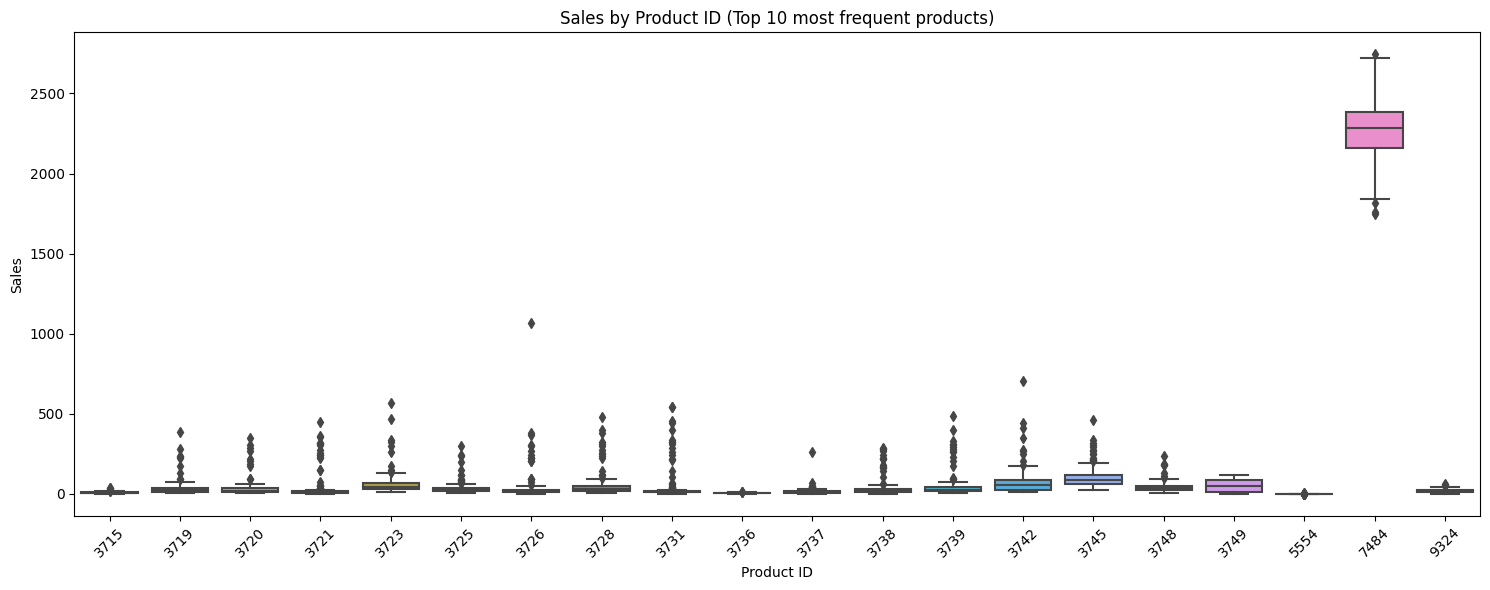

In [110]:
# Building a boxplot for 'sales' by 'product_id' using subsampling
sample_data = df[df['product_id'].isin(df['product_id'].value_counts().head(20).index)]

plt.figure(figsize=(15, 6))
sns.boxplot(x='product_id', y='sales', data=sample_data)
plt.title('Sales by Product ID (Top 10 most frequent products)')
plt.ylabel('Sales')
plt.xlabel('Product ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sales by Product ID - The graph shows that the median sales, range of values and presence of outliers are different for different products. 
Some products have higher average sales (7484) and fewer outliers, while other products have lower average sales but more outliers. 
This may indicate different demand and sales characteristics for different products.

Let's take a closer look at the data for product_id 7484, since this is what caught our attention in the previous chart.

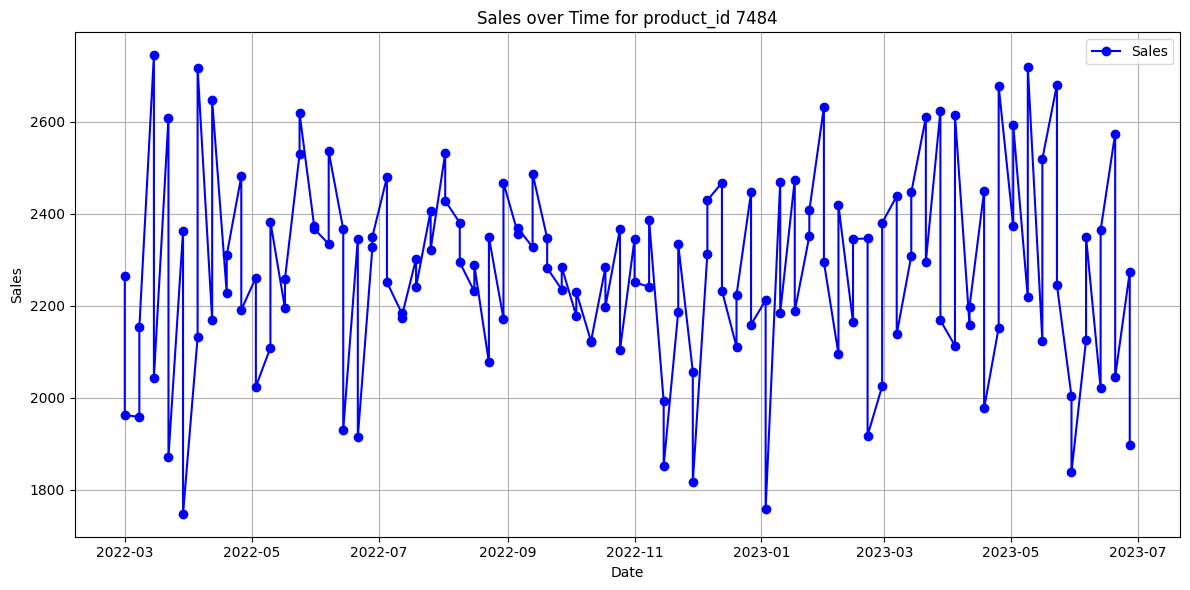

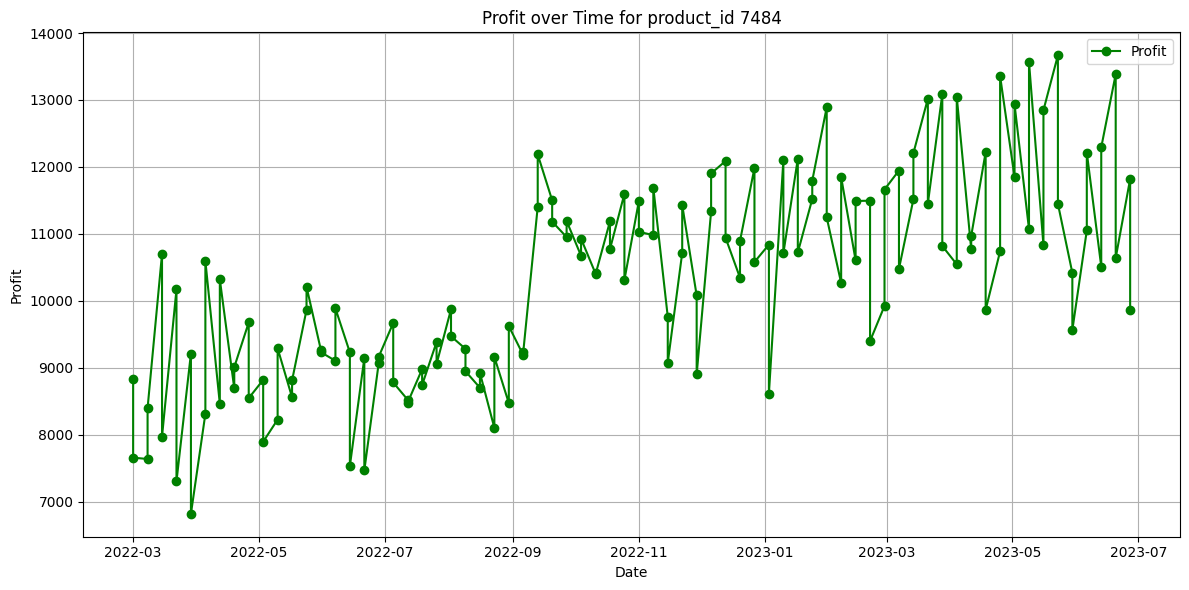

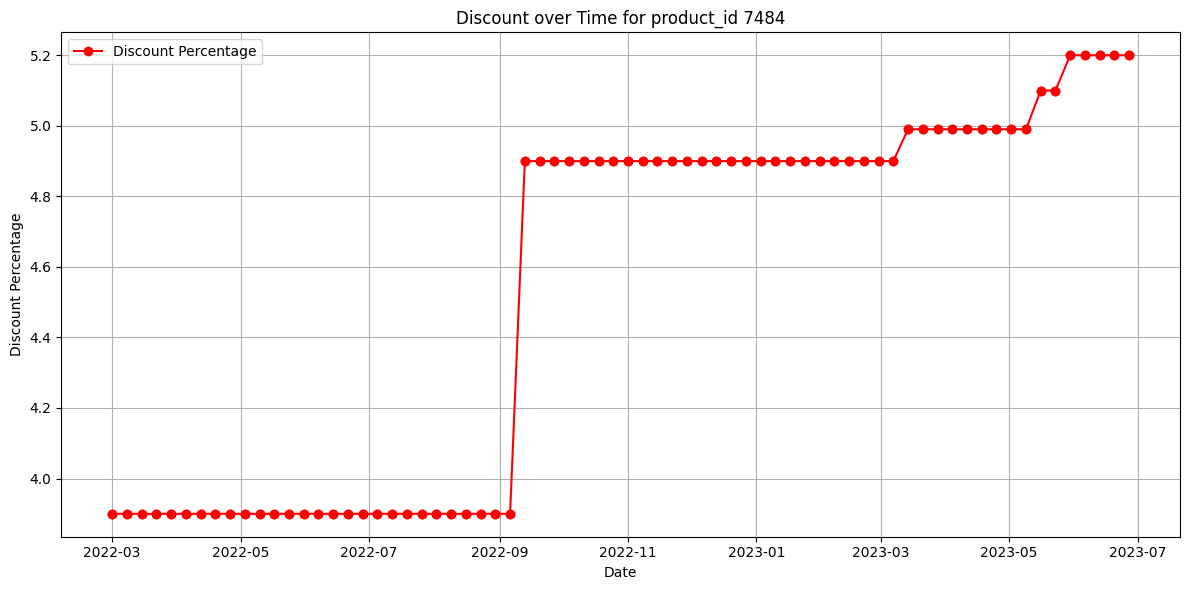

In [130]:
# Data filtration for product_id 7484
product_7484 = df[df['product_id'] == 7484]
# Sort data by date
product_7484 = product_7484.sort_values(by='date')

# Profit calculationd
product_7484['profit'] = product_7484['sales'] * (product_7484['shelf_price'] - product_7484['shelf_price'] * product_7484['discount_percent'])


# Sales plot
plt.figure(figsize=(12, 6))
plt.plot(product_7484['date'], product_7484['sales'], label='Sales', color='blue', marker='o')
plt.title('Sales over Time for product_id 7484')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Profit plot
plt.figure(figsize=(12, 6))
plt.plot(product_7484['date'], product_7484['profit'], label='Profit', color='green', marker='o')
plt.title('Profit over Time for product_id 7484')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Price plot
plt.figure(figsize=(12, 6))
plt.plot(product_7484['date'], product_7484['shelf_price'], label='Discount Percentage', color='red', marker='o')
plt.title('Discount over Time for product_id 7484')
plt.xlabel('Date')
plt.ylabel('Discount Percentage')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We see that sales of this product are constant over time, however, due to the increase in its cost, stores began to receive more profit as a result of the sale of this product. Raising the price turned out to be a smart move.

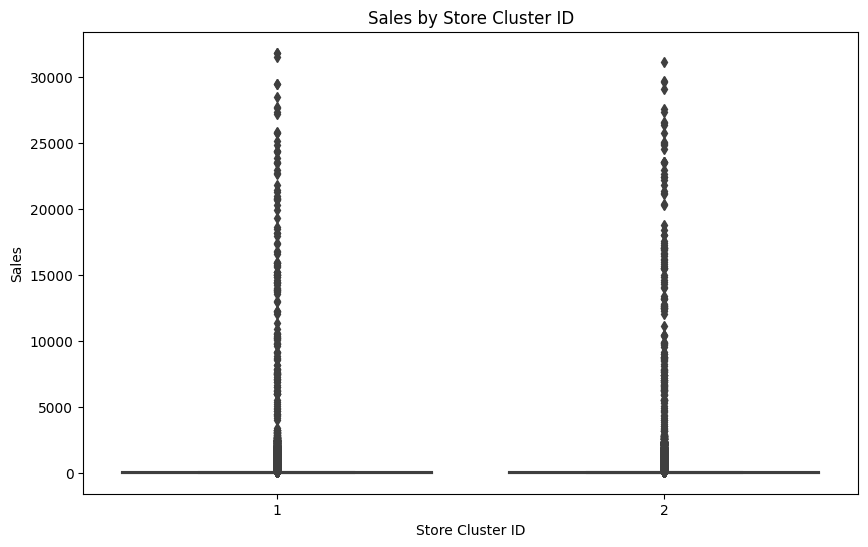

In [108]:
#  boxplot for 'sales' by 'store_cluster_id'
plt.figure(figsize=(10, 6))
sns.boxplot(x='store_cluster_id', y='sales', data=df)
plt.title('Sales by Store Cluster ID')
plt.ylabel('Sales')
plt.xlabel('Store Cluster ID')
plt.show()

In [131]:
# median sales by store:
medians_by_store = df.groupby('store_cluster_id')['sales'].median()
print(medians_by_store)

store_cluster_id
1    6.00
2    6.57
Name: sales, dtype: float64


Based on the boxplot for the sales feature in different store_cluster_id categories, the following observations can be made:

 - Median sales in cluster 2 are higher than in cluster 1.
 - Both clusters have a wide range of sales values, indicating that there are products with different sales levels in each cluster.
 - Both clusters contain outliers in sales, which may indicate the presence of products with very high or very low sales.
 
Thus, store clusters have different sales characteristics. This may be due to different sales strategies, product mixes, or customer demographics in these clusters.

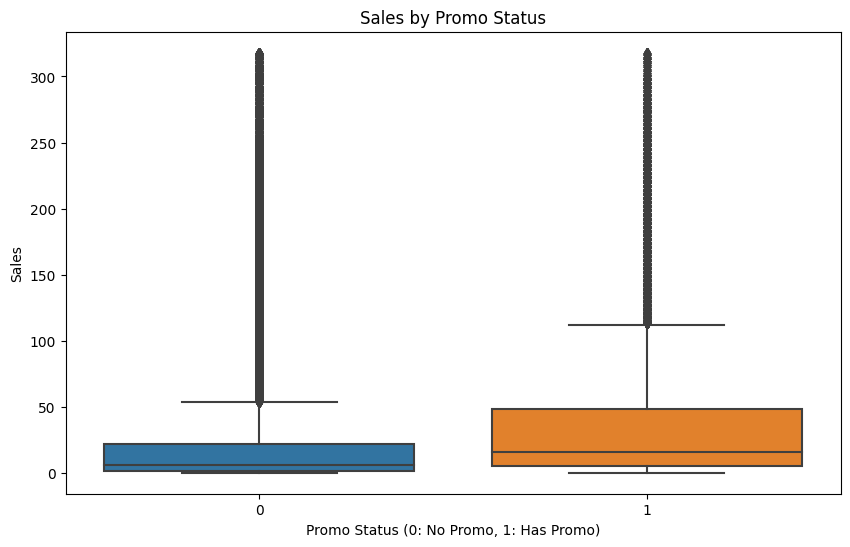

In [135]:
#  boxplot for 'sales' by 'has_promo'
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_promo', y='sales', data=df[df['sales'] <= df['sales'].quantile(0.99)])
plt.title('Sales by Promo Status')
plt.ylabel('Sales')
plt.xlabel('Promo Status (0: No Promo, 1: Has Promo)')
plt.show()

In [132]:
# median sales by has_promo:
medians_by_store = df.groupby('has_promo')['sales'].median()
print(medians_by_store)

has_promo
0     6.0
1    17.0
Name: sales, dtype: float64


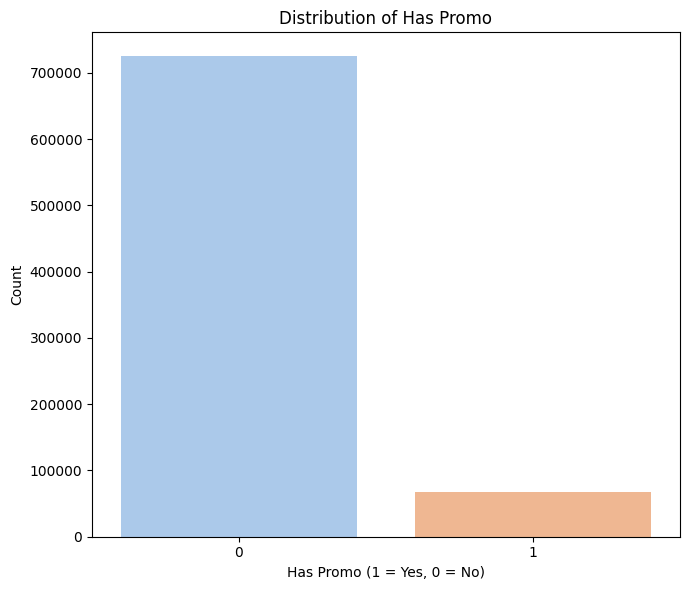

In [149]:
# Distribution plot for has_promo
plt.figure(figsize=(7, 6))
sns.countplot(data=df, x='has_promo', palette='pastel')
plt.title('Distribution of Has Promo')
plt.xlabel('Has Promo (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Based on the boxplot (and distribution plot) for the sales feature in different has_promo categories, the following observations can be made:

 - Sales of discounted items (has_promo = 1) are higher than those of non-discounted items (has_promo = 0) with respect to the median value.
 - Non-discounted items have a wider range of sales values, indicating a greater variety of items with different sales levels.
 - Both categories have outliers in sales, but discounted items have more high outliers.
 
These observations may indicate that discounts are effective in stimulating sales, and discounted products sell better on average. This is an important observation that can be used when planning future promotions or determining optimal prices for goods.

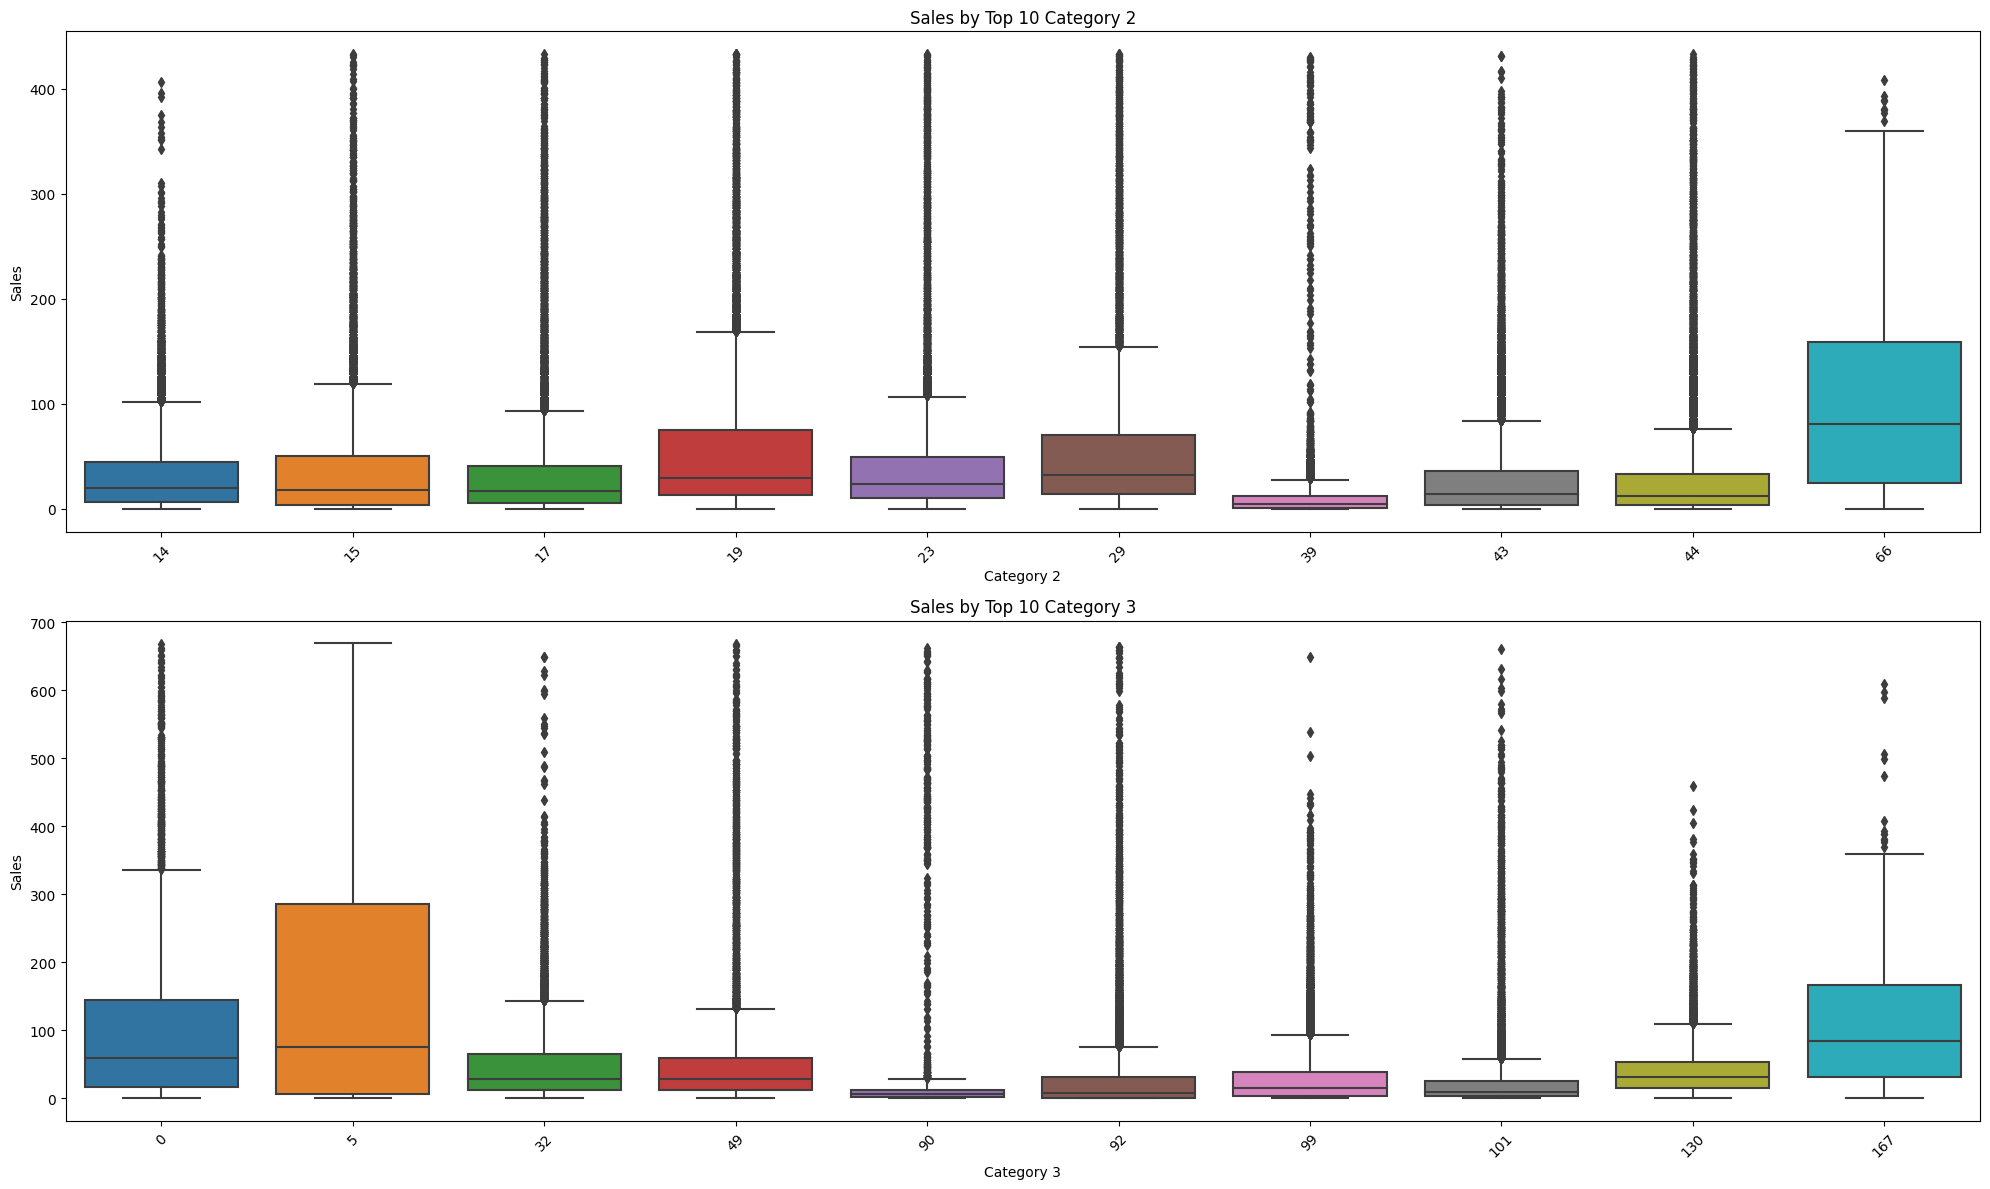

In [136]:
# choose top-10 cats from category_2 and category_3 by sales
top20_cat2 = df.groupby('category_2')['sales'].sum().nlargest(10).index
top20_cat3 = df.groupby('category_3')['sales'].sum().nlargest(10).index


df_cat2_top20 = df[df['category_2'].isin(top20_cat2)]
df_cat3_top20 = df[df['category_3'].isin(top20_cat3)]

#  boxplots
plt.figure(figsize=(20, 12))

# Sales by Top 10 category_2
plt.subplot(2, 1, 1)
sns.boxplot(x='category_2', y='sales', data=df_cat2_top20[df_cat2_top20['sales'] <= df_cat2_top20['sales'].quantile(0.99)])
plt.title('Sales by Top 10 Category 2')
plt.ylabel('Sales')
plt.xlabel('Category 2')
plt.xticks(rotation=45)

# Sales by Top 10 category_3
plt.subplot(2, 1, 2)
sns.boxplot(x='category_3', y='sales', data=df_cat3_top20[df_cat3_top20['sales'] <= df_cat3_top20['sales'].quantile(0.99)])
plt.title('Sales by Top 10 Category 3')
plt.ylabel('Sales')
plt.xlabel('Category 3')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

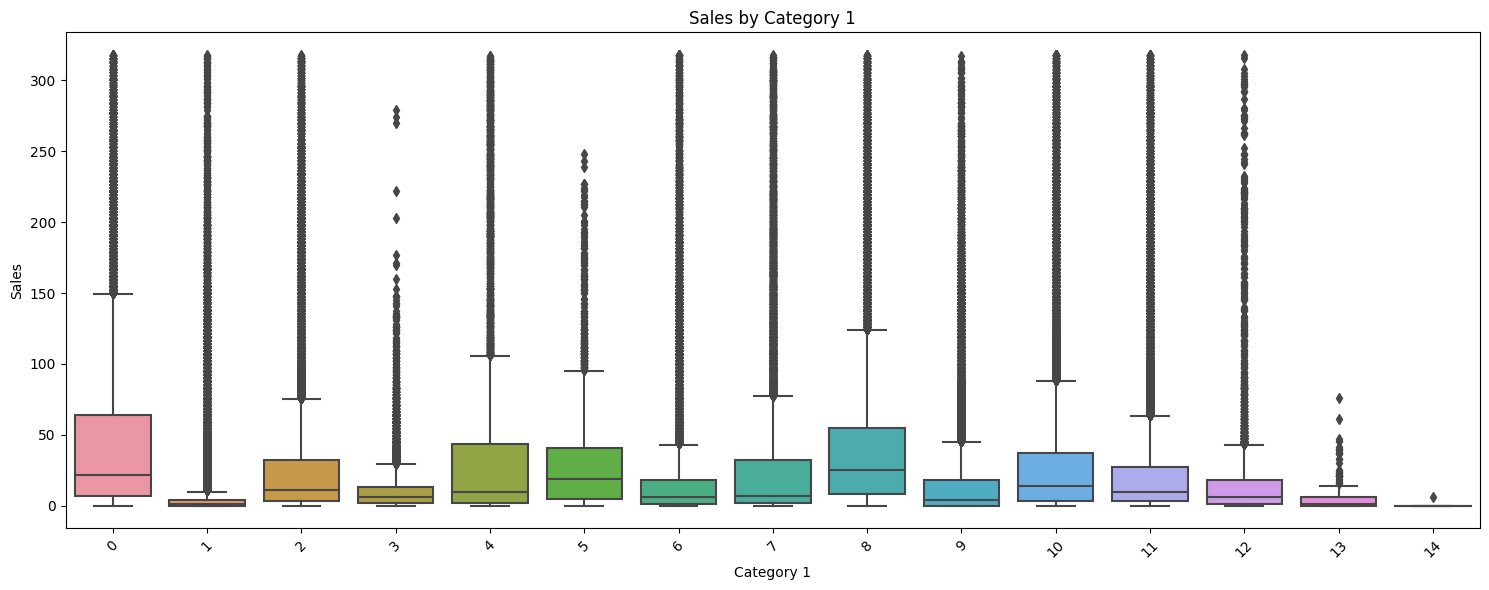

In [137]:
#  boxplot for 'sales' by 'category_1'
plt.figure(figsize=(15, 6))
sns.boxplot(x='category_1', y='sales', data=df[df['sales'] <= df['sales'].quantile(0.99)])
plt.title('Sales by Category 1')
plt.ylabel('Sales')
plt.xlabel('Category 1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the last 3 graphs we see the distribution of sales by categories of products.

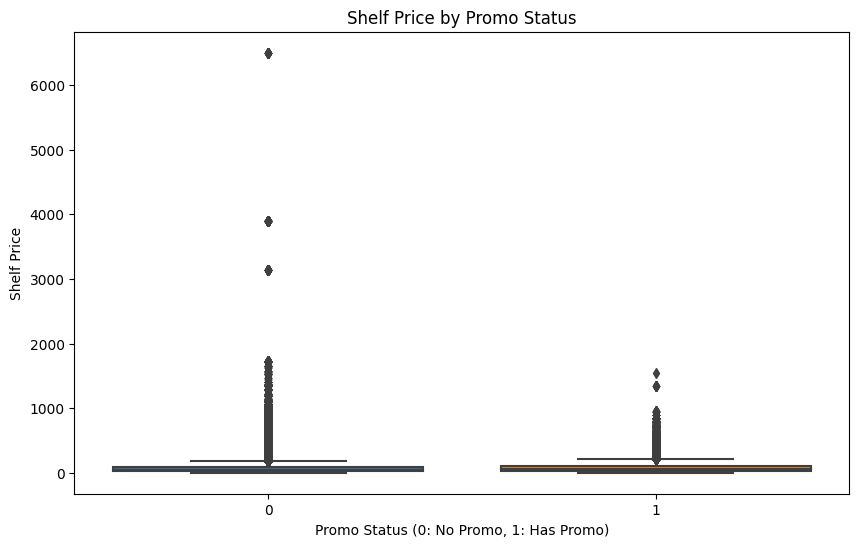

In [141]:
#  boxplot  'shelf_price' by 'has_promo'
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_promo', y='shelf_price', data=df[df['sales'] <= df['sales'].quantile(0.99)])
plt.title('Shelf Price by Promo Status')
plt.ylabel('Shelf Price')
plt.xlabel('Promo Status (0: No Promo, 1: Has Promo)')
plt.show()

In [143]:
# median price by has_promo:
medians_by_store = df.groupby('has_promo')['shelf_price'].median()
print(medians_by_store)

has_promo
0    42.9
1    50.9
Name: shelf_price, dtype: float64


Shelf Price by Promo Status:

 - Discounted items (has_promo = 1) generally have a higher median price than non-discounted items. This may indicate that discounts are usually offered on items in the higher price range.
 - Both stock statuses have outliers in their prices. However, high price outliers are more pronounced for discounted products, further supporting the above-mentioned hypothesis.

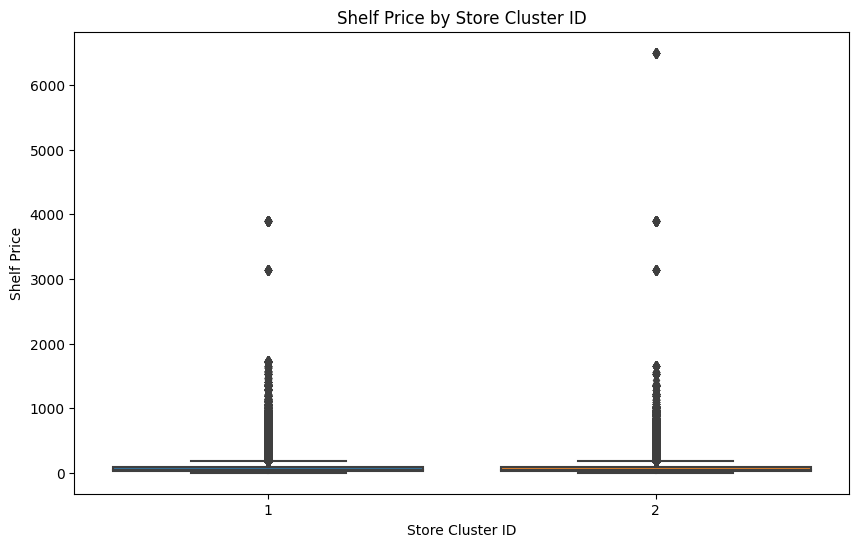

In [142]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='store_cluster_id', y='shelf_price', data=df[df['sales'] <= df['sales'].quantile(0.99)])
plt.title('Shelf Price by Store Cluster ID')
plt.ylabel('Shelf Price')
plt.xlabel('Store Cluster ID')
plt.show()

In [144]:
# median price by has_promo:
medians_by_store = df.groupby('store_cluster_id')['shelf_price'].median()
print(medians_by_store)

store_cluster_id
1    43.79
2    43.90
Name: shelf_price, dtype: float64


Let's look at the diagram of shelf prices by store cluster identifiers:

 - Median prices in Cluster 1 are slightly lower than those in Cluster 2. This may indicate that stores in Cluster 1, on average, offer items at lower prices or have a larger selection of items at lower prices.
 - The spread of prices in both clusters is quite similar, although the outliers are slightly higher in the second cluster. This may indicate that some premium products are available in Cluster 2 stores.
These differences between clusters may be due to different pricing strategies, different product mixes, or differences in customer demographics.

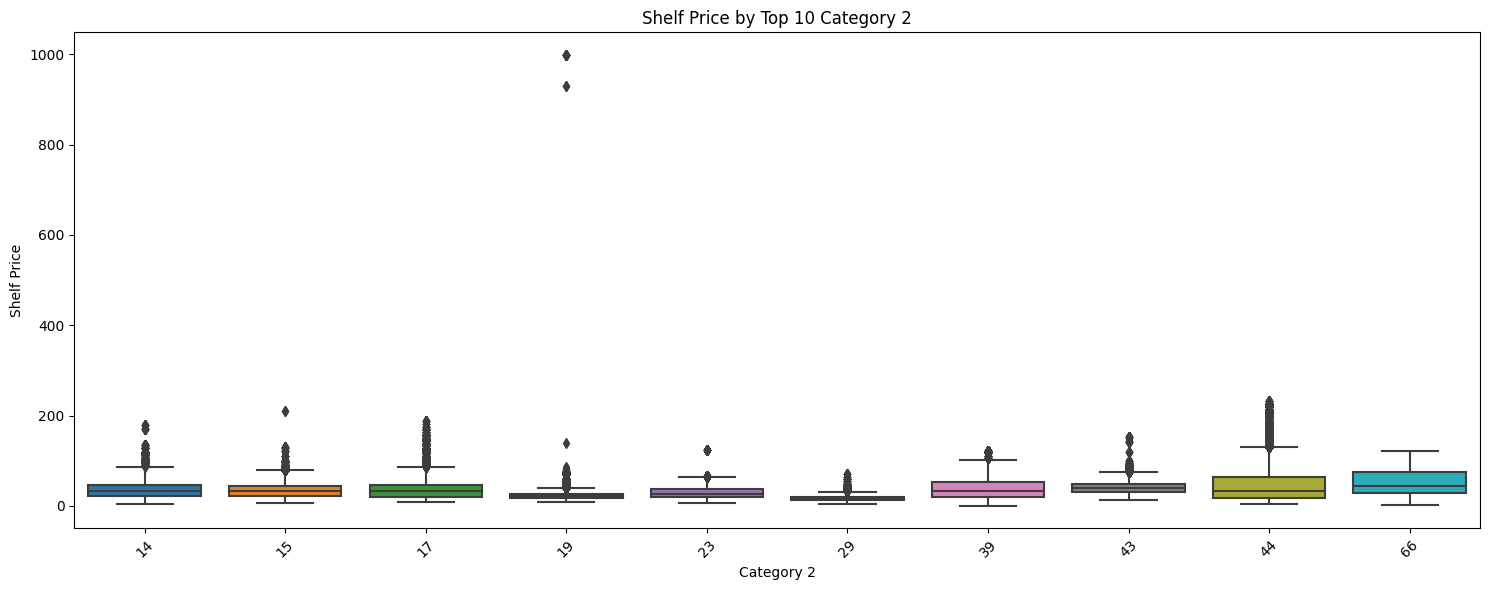

In [146]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='category_2', y='shelf_price', data=df_cat2_top20)
plt.title('Shelf Price by Top 10 Category 2')
plt.ylabel('Shelf Price')
plt.xlabel('Category 2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's look at the shelf price chart for the top 20 category 2:

 - As with the previous categories, there are notable differences in median prices between categories. 
 - Most categories have a wide range of prices, indicating that there are products at different price points within each category.
 
There are price deviations in almost all categories, which indicates the presence of expensive goods.

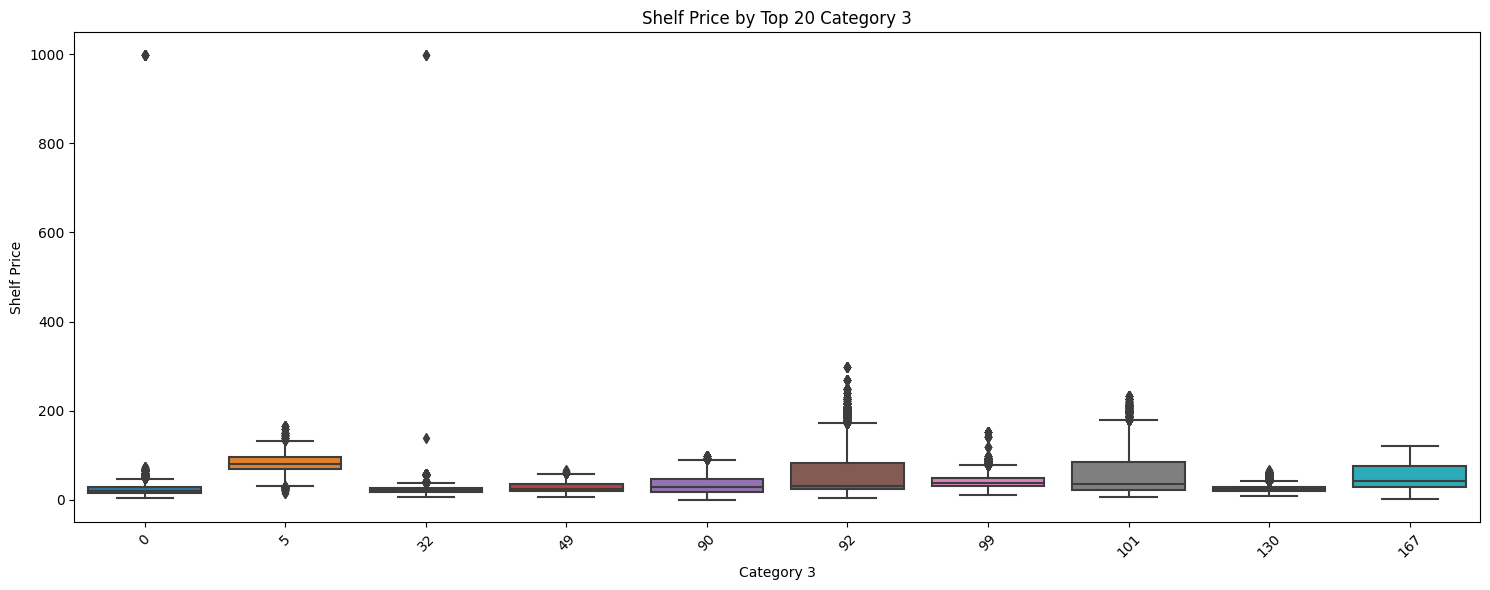

In [147]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='category_3', y='shelf_price', data=df_cat3_top20)
plt.title('Shelf Price by Top 10 Category 3')
plt.ylabel('Shelf Price')
plt.xlabel('Category 3')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's look at the shelf price chart for the top 20 category 3:

 - There are also notable differences in average prices in this category..
 - Some categories have relatively low average prices but still command high prices. This may indicate that there are many products in these categories.
As is the case with other categories, there are also noticeable price variations in most categories.

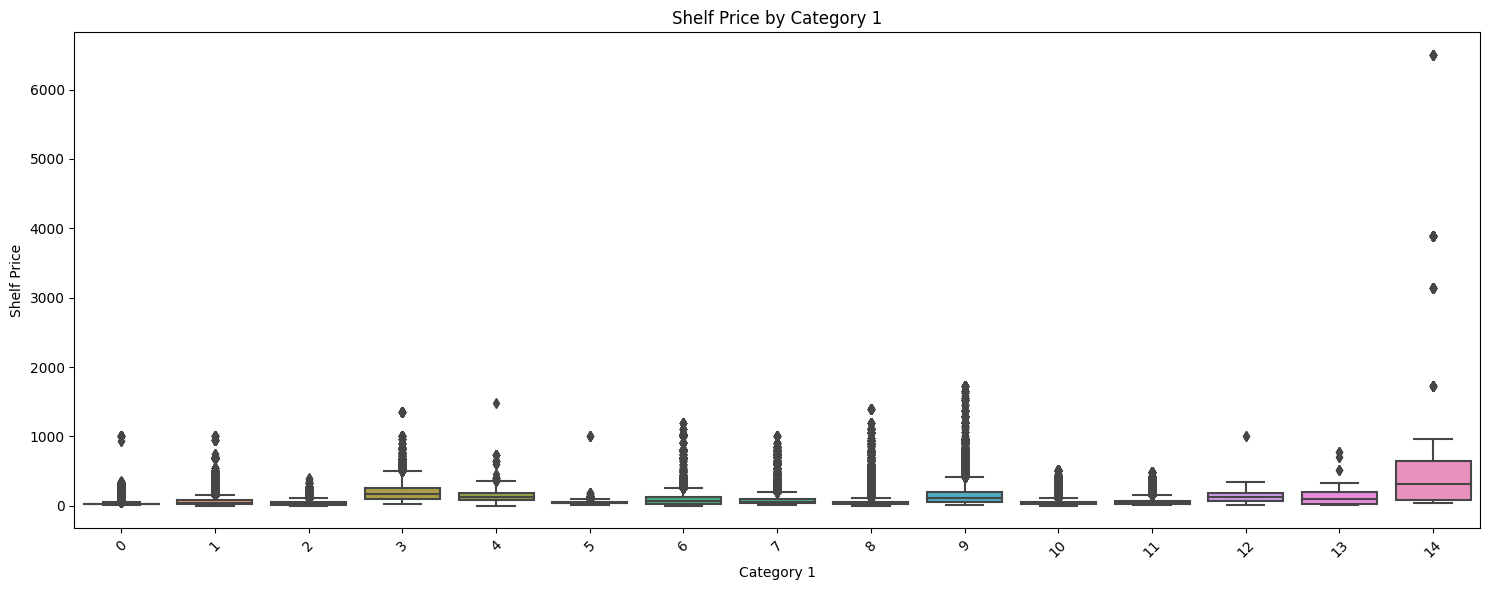

In [116]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='category_1', y='shelf_price', data=df)
plt.title('Shelf Price by Category 1')
plt.ylabel('Shelf Price')
plt.xlabel('Category 1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's look at the shelf price chart for categories 1:

 - There are noticeable differences in average prices between different categories. For example, category 14 has a higher average price compared to other categories.
 - Some categories, such as 9 and 14, have a wide range of prices, which may indicate that these categories have a variety of products, from cheap to expensive.
 - Many categories have price discrepancies, indicating very expensive items. This may be due to the presence of premium products in these categories.

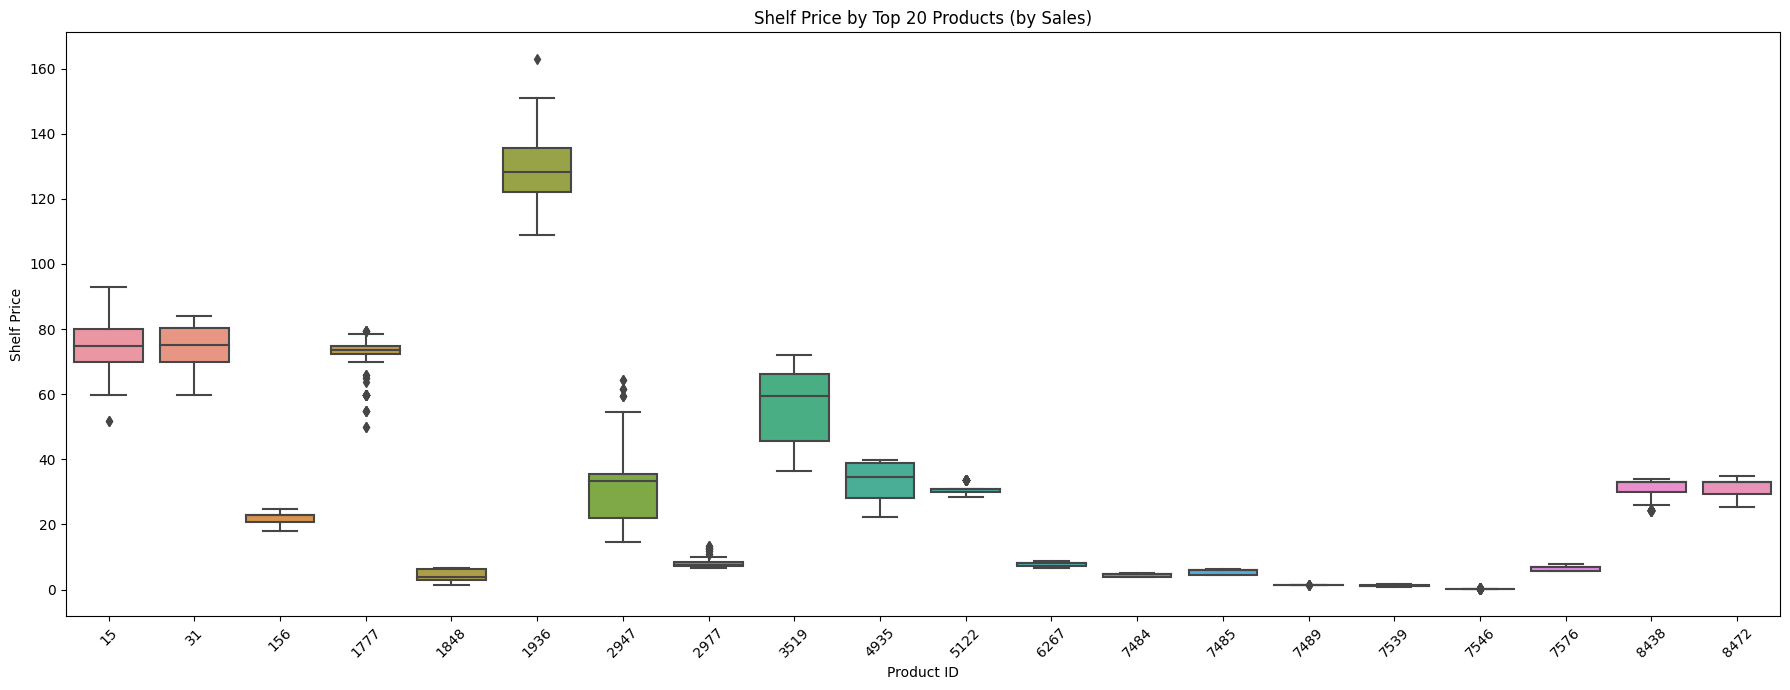

In [148]:

top20_products = df.groupby('product_id')['sales'].sum().nlargest(20).index

df_top20_products = df[df['product_id'].isin(top20_products)]

plt.figure(figsize=(18, 7))
sns.boxplot(x='product_id', y='shelf_price', data=df_top20_products)
plt.title('Shelf Price by Top 20 Products (by Sales)')
plt.ylabel('Shelf Price')
plt.xlabel('Product ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's look at the shelf price chart for the top 20 products (by sales volume):

 - There are notable differences in the price distribution between the leading products. For example, products with IDs such as "1936", "15" and "31" have a higher average price compared to other products in the top 20.
While most products have a fairly compact price distribution (small interquartile range), some products, such as IDs "1936" and "2947", have a wider price range, which may indicate that there are different versions or variants of these products. with different prices.


In [152]:
df

,date,product_id,store_cluster_id,sales,shelf_price,has_promo,category_3_promo_coverage,discount_percent,category_1,category_2,category_3,month,revenue
0,2023-04-11,0,1,31.0,26.90,0,0.032787,0.000000,0,0,0,2023-04,833.900000
1,2023-04-11,1,1,0.0,384.49,0,0.000000,0.000000,1,1,1,2023-04,0.000000
2,2023-04-11,2,2,0.0,15.20,0,0.000000,0.000000,2,2,2,2023-04,0.000000
3,2023-04-11,3,1,12.0,149.90,1,0.058824,0.200133,0,0,3,2023-04,1438.800001
4,2023-04-11,4,1,0.0,274.99,0,0.000000,0.000000,1,1,1,2023-04,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
816342,2023-06-13,11026,1,0.0,97.99,0,0.153846,0.000000,6,52,134,2023-06,0.000000
816343,2023-05-09,10969,1,4.0,39.79,0,0.272727,0.000000,6,52,134,2023-05,159.160000
816344,2023-06-13,10973,2,1.0,84.99,0,0.181818,0.000000,6,52,134,2023-06,84.990000
816345,2023-01-31,10971,1,30.0,55.74,0,0.000000,0.000000,6,52,134,2023-01,1672.200000


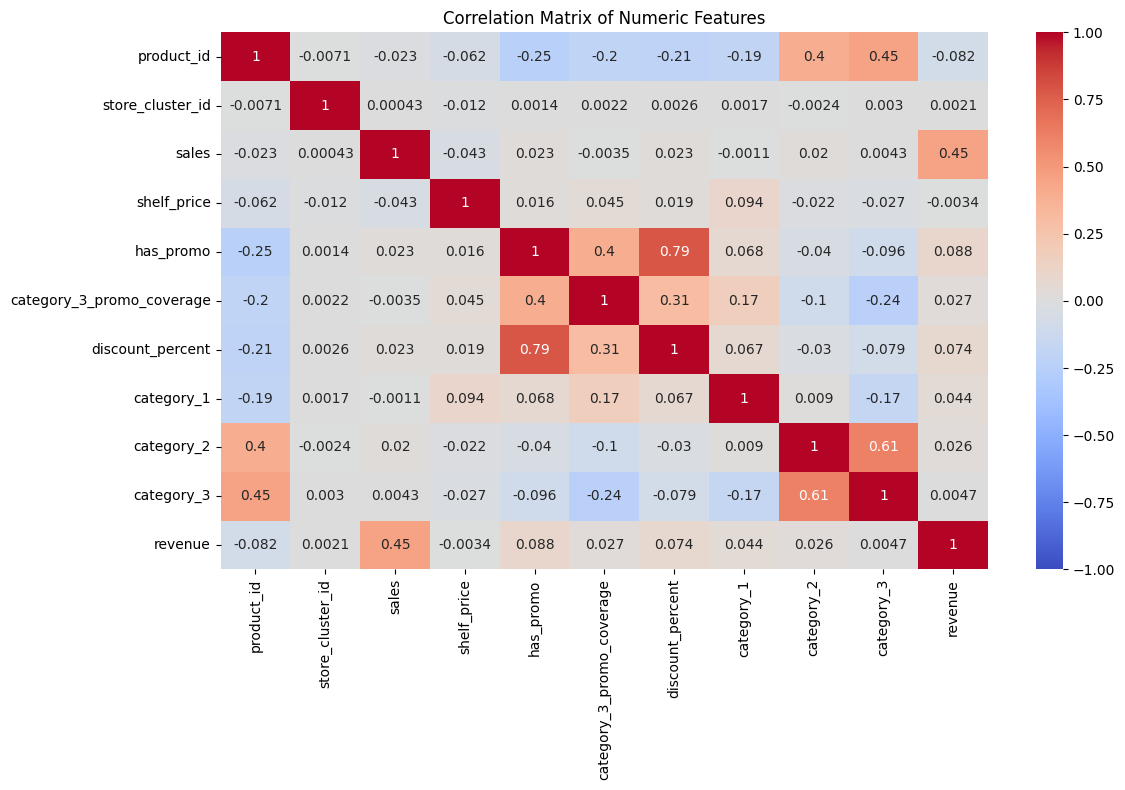

In [153]:
# Corr matrix
correlation_matrix = df.drop(['date','month'], axis=1).corr()

# ВCorr matrix plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

Correlation analysis of features:

 - Sales and discount percentage. There is a small positive correlation between sales and discount percentage (0.023), which may indicate that discounted items tend to sell better.
 - Has a percentage of promotions and discounts: a significant positive correlation (0.788), which is expected since promotional products often have discounts.
 - Category 3 Promotion Coverage and Promotion Availability: The moderate positive correlation (0.396) indicates that the more products in Category 3 receive promotions, the more likely it is that that product will also be promoted.
 - Category 2 and Category 3: The significant positive correlation (0.618) may indicate some hierarchical structure between these categories.
 - Product ID. This feature has little correlation with other attributes, which may be due to the fact that it is a unique identifier for a product.

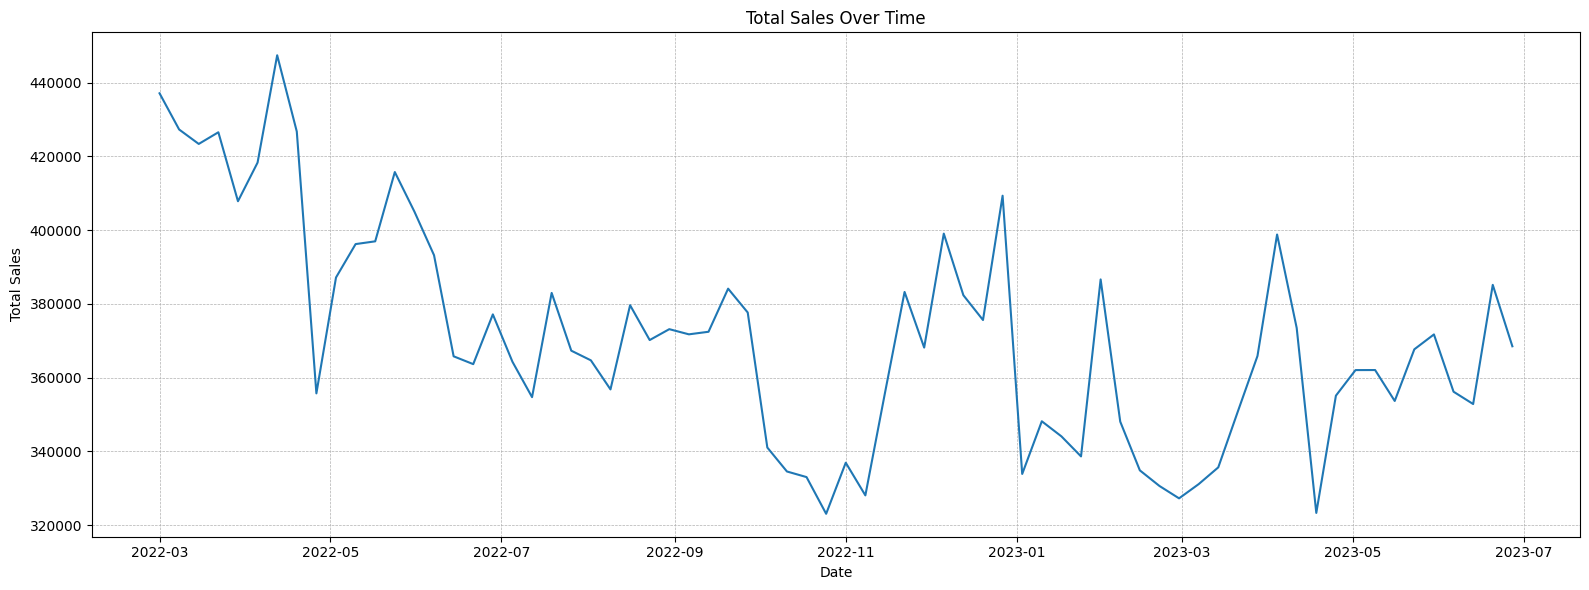

In [157]:
# Sales by dates
plt.figure(figsize=(16, 6))
sns.lineplot(data=df, x='date', y='sales', estimator='sum', errorbar=None)
plt.title('Total Sales Over Time')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Conclusions:

 - Trends and Seasonality: Sales tend to increase from March 2022 to June 2022, after which there is a slight decline. This may be due to seasonal fluctuations or other external factors.
 - Changes: There are weekly sales fluctuations which may be due to weekly promotions or other events.
 
This graph will help you understand sales trends over time and identify possible trends and seasonal variations.

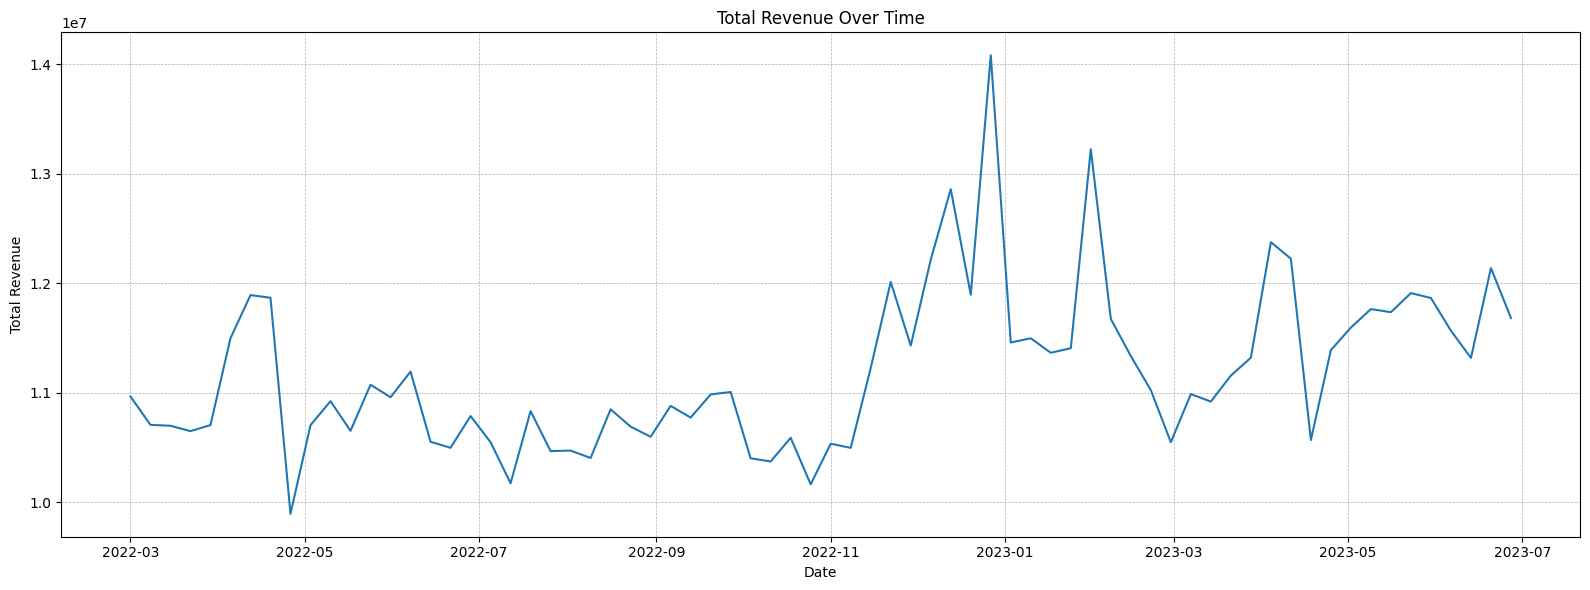

In [159]:
# Revenue by dates
plt.figure(figsize=(16, 6))
sns.lineplot(data=df, x='date', y='revenue', estimator='sum', errorbar=None)
plt.title('Total Revenue Over Time')
plt.ylabel('Total Revenue')
plt.xlabel('Date')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Conclusions:

 - Trends: Total revenue trends upward from March 2022 to July 2022, after which it declines. This trend is similar to the sales trend, suggesting that the increase in profits was due to increased sales volume.
 - Seasonal variations. There are also weekly revenue fluctuations that may be due to promotions or other marketing efforts.
 - Falling profits: After July 2022, profits fell sharply and stabilized at lower levels. This may be due to a change in pricing strategy, reduced discounts, or other external factors.
